![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Modelo Epidemiológico Clássico: SEIR

Neste documento investigamos a dinâmica epidemiológica da COVID19 empregando um modelo cĺássico conhecido como SEIR e algumas variações imediatas. Uma vez definido o modelo, empregamos dados históricos para estimar seus parâmetros para o caso brasileiro. Essas estimativas são usadas então para gerar dois conjuntos de dados simulados: sem e com medidas de miticação. Esses dois resultados são salvos em arquivos CSV para uso posterior em outras análises.

Esta implementação serve como base para investigações mais profundas, e pode ser customizada e usado de diversos modos por eventuais interessados. É possível, por exemplo, experimentar com medidas de mitigação diferentes.



**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [1]:
import os
import math
import hyperopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/salem/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/home/salem/anaconda3/lib/python3.7/site-packages/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable
/home/salem/anaconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:280: DeprecationWarning: Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.
  war

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

Se necessário, ajuste o diretório de trabalho para ser o que contém este *notebook*.

In [3]:
#print(os.getcwd())
#os.chdir('covid19-analytics/notebooks')
#os.getcwd()

## Parâmetros das Simulações

Empregaremos simulações para efetivamente executar os modelos que serão desenvolvidos abaixo. Para tanto, é necessário definir-se alguns parâmetros gerais.

Data de início da epidemia.

In [4]:
epidemic_start_date = pd.Timestamp(2020, 3, 12)

Quantida de dias.

In [5]:
epidemic_duration_in_days = 365

Tamanho da população.

In [6]:
population_size = 200 * 1e6 #18000000

Infectados inicialmente.

In [7]:
initially_infected = 52

Onde está a pasta base que contém os dados?

In [8]:
data_folder = '../data/'

Qual coluna dos dados históricos reais devemos usar para ajustar os parâmetros dos modelos?

In [9]:
data_column_to_fit =  'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_FROM_SRAG'  #'total_cases_ESTIMATED'

Quando empregarmos dados reais para calibrar os parâmetros do modelo, qual país devemos usar?

In [10]:
target_location = 'Brazil'

Devemos usar os dados disponíveis para modificar algum dos parâmetros acima? Em caso positivo, dados demográficos e epidêmicos serão substituídos.

In [11]:
infer_parameters_from_data = True

Onde queremos armazenar resultados do modelo para posterior.

In [12]:
results_folder = '../results/'

Algum suffixo adicional para marcar o nome dos resultados salvos?

In [13]:
results_suffix = ''

### Parâmetros Injetados Externamente

Este *notebook* pode também ser executado com a biblioteca [papermill](https://papermill.readthedocs.io/en/latest/index.html), de modo a customizar parâmetros sem a necessidade de editá-los diretamente aqui. Tais parâmetros customizados serão colocados na célula abaixo quando existirem, e assim tomarão o lugar dos valores dados acima.

In [14]:
# custom papermill parameters

## Funções Auxiliares

E uma função para auxiliar no desenho de gráficos. Opcionalmente, se um nome de arquivo for especificado, a função irá salvar a imagem resultante.

In [15]:
def plot_simulation_output(df_simulated_data, zoom_on=None, zoom_length=60, file_path_base=results_folder, file_name=None):
    
    def aux_file_path(x):
        return file_path_base + 'seir_' + file_name + f'_{target_location.lower()}_{x}' + results_suffix + '.png'
        
    ax = sns.lineplot(data=df_simulated_data[['S', 'E', 'I', 'R', 'E+I', 'E+I+R']])
    ax.set_title('Visão Geral da Epidemia')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('overview'), format='png')
    plt.figure()
    
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I', 'E+I+R']])
    ax.set_title('Apenas Expostos e Infecciosos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI'), format='png')
    plt.figure()
    
    peak_date = df_simulated_data["I"].idxmax().date()
    
    if zoom_on is None:    
        zoom_on = peak_date - pd.DateOffset(days=20)
        
    zoom_end = (pd.Timestamp(zoom_on) + pd.DateOffset(days=zoom_length)).date()
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I']][zoom_on:zoom_end], markers=True)
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI-zoom'), format='png')
    ax.set_title(f'Zoom (de {zoom_on} a {zoom_end})')
    plt.figure()
    
    df_I_delta = df_simulated_data[['I_delta']]
    df_I_delta = df_I_delta[df_I_delta > 0]
    ax = sns.lineplot(data=df_I_delta)
    ax.set_title('Infecciosos novos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('I_delta'), format='png')
    plt.figure()
    

In [16]:
def plot_curve_fitting(df_simulation_data, df_data_target, target_location, best, comparison_date=None, file_name=None):
    peak_date = df_data_target["total_cases"].idxmax().date()
    if comparison_date is None:
        comparison_date = peak_date - pd.DateOffset(days=1)
        
    df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
    
    ax = sns.lineplot(data=df_simulation_vs_real[['E+I','E+I+R', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_2', 
                                                  'total_cases_ESTIMATED_FROM_SRAG']]\
                                           [comparison_date - pd.DateOffset(days=40):comparison_date], 
                 markers=True)

    ax.set_title(f'Simulação (E+I+R) frente aos dados históriocos. Linha vertical=estimativa de intervenção (se houver).')
    
    if 'duration_1' in best:
        intervention_date_1 = epidemic_start_date + pd.DateOffset(days=int(best['duration_1']))
        plt.axvline(intervention_date_1, color='red')

    if ('duration_1' in best) and ('duration_2' in best):
        intervention_date_2 = epidemic_start_date +  pd.DateOffset(days=int(best['duration_1'])) + pd.DateOffset(days=int(best['duration_2']))
        plt.axvline(intervention_date_2, color='red')

    if file_name is not None:
        ax.figure.savefig(results_folder + file_name + f'_{target_location.lower()}' + results_suffix + '.png', 
                          format='png')

## Leitura e Preparação de Dados para Calibragem de Modelos

Mais adiante no *notebook*, empregaremos dados históricos observados para calibrar os parâmetros da simulação.  Vamos empregar dados do [Our World in Data](https://ourworldindata.org/coronavirus-source-data ). Convém assim tornar esses dados disponíveis. Isso inclui não apenas dados sobre a epidemia em si, mas também algumas informações demográficas adicionais. 

In [17]:
df_epidemy_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])
df_locations_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/locations.csv')

# enrich epidemy data with additional demographic information
df_epidemy_data = df_epidemy_data.merge(df_locations_data, on='location')
df_epidemy_data.head(2)

,date,location,new_cases,new_deaths,total_cases,total_deaths,countriesAndTerritories,continent,population_year,population
0,2019-12-31,Afghanistan,0,0,0,0,Afghanistan,Asia,2020.0,38928341.0
1,2020-01-01,Afghanistan,0,0,0,0,Afghanistan,Asia,2020.0,38928341.0


Selecionemos apenas dados sobre o país de interesse.

In [18]:
df_data_target = df_epidemy_data[df_epidemy_data['location']==target_location].copy().set_index(['date']).drop('location', axis=1)

In [19]:
df_srag_adjustment_multipliers = pd.read_csv(f'{results_folder}srag_adjustment_multipliers.brazil.csv', parse_dates=['date'], index_col=0)
df_srag_adjustment_multipliers.tail()

,SRAG_adjustment_multiplier
date,
2020-04-07,3.595084
2020-04-08,3.595084
2020-04-09,3.595084
2020-04-10,3.595084
2020-04-11,3.595084


Antes de prosseguir, vamos enriquer esses dados com algumas suposições.

,new_cases,new_deaths,total_cases,total_deaths,countriesAndTerritories,continent,population_year,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,,,,
2020-04-28,4613,338,66501,4543,Brazil,South America,2020.0,212559409.0,NaN,997515,347322.343559
2020-04-29,5385,474,71886,5017,Brazil,South America,2020.0,212559409.0,NaN,1078290,366681.872391
2020-04-30,6276,449,78162,5466,Brazil,South America,2020.0,212559409.0,NaN,1172430,389244.621312
2020-05-01,7218,435,85380,5901,Brazil,South America,2020.0,212559409.0,NaN,1280700,415193.939623
2020-05-02,6209,428,91589,6329,Brazil,South America,2020.0,212559409.0,NaN,1373835,437515.817898


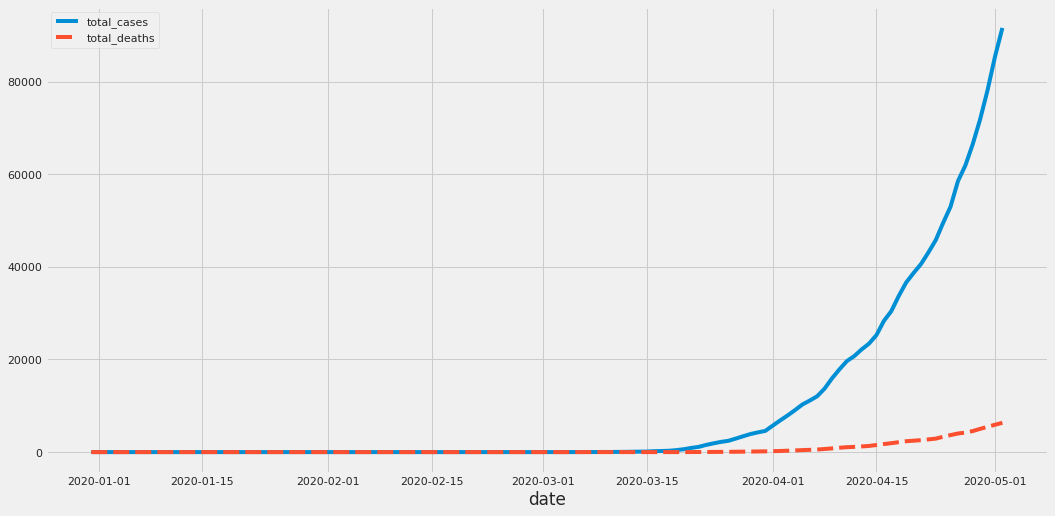

In [20]:
df_data_target['total_cases_ESTIMATED'] = (df_data_target['total_deaths'] / 0.05).shift(-7)
df_data_target['total_cases_ESTIMATED_2'] = 15 * df_data_target['total_cases']

# we have data for SRAG in Brazil only 
if target_location == 'Brazil':
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = \
        (df_data_target['new_cases'] * df_srag_adjustment_multipliers['SRAG_adjustment_multiplier'].reindex_like(df_data_target, method='ffill'))\
            .cumsum()
else:
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = df_data_target['new_cases'] * np.nan

sns.lineplot(data=df_data_target[['total_cases', 'total_deaths']])
df_data_target.tail()

### Substituição de Parâmetros

Se requisitado, vamos substituir alguns dos parâmetros por valores presentes nos dados.

In [21]:
df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]

Timestamp('2020-03-12 00:00:00')

In [22]:
if infer_parameters_from_data:
    epidemic_start_date = df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]
    
    first_date_row = df_data_target.loc[epidemic_start_date]
    population_size = first_date_row['population']
    initially_infected = first_date_row[data_column_to_fit] #['total_cases']
    
    print(f'NEW VALUES: epidemic_start_date={epidemic_start_date}, population_size={population_size}, initially_infected={initially_infected}')
    

NEW VALUES: epidemic_start_date=2020-03-12 00:00:00, population_size=212559409.0, initially_infected=780


Filtremos os dados a partir da data de interesse.

In [23]:
df_data_target = df_data_target[epidemic_start_date:]

## Modelo SEIR

O [modelo SEIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) é um dos modos clássicos de se representar a dinâmica de epidemias. Trata-se de um chamado "modelo de compartimento", no qual temos alguns compartimentos principais:

  - S(t): número de indivíduos suscetíveis em função do tempo.
  - E(t): número de expostos, mas ainda não transmissores, em função do tempo.
  - I(t): número de indivíduos infecciosos em função do tempo.
  - R(t): número de indivíduos que se recuperam em função do tempo.
  
São também necessários dois outros parâmetros, que definem taxas de transição entre compartimentos:
  
  - beta: valor entre 0.0 e 1.0 que define a taxa de S para E (i.e., taxa de exposição)
  - alpha: valor entre 0.0 e 1.0 que define a taxa de E para I (i.e., taxa de contaminação)
  - gamma: valor entre 0.0 e 1.0 que define a taxa de I para R (i.e., taxa de recuperação)

Tradicionalmente, esse modelo é tratado via equações diferenciais. Aqui, adotaremos uma implementação via simulações estocásticas, o que nos permitirá posteriormente realizar modificações variadas que talvez não sejam tratáveis analiticamente.

### Funções Auxiliares

Antes de prosseguir, vamos definir algumas funções auxliares que garantirão que os valores acrescidos ou subtraídos nos diversos compartimentos não ultrapassem valores limites.

In [24]:
def aux_enforce_max_addition(Q, delta):
    if Q - delta <= 0:
        return Q
    
    else:
        return delta
    
def aux_enforce_max_removal(Q, delta):
    if Q + delta <= 0:
        return -Q
    else:
        return delta

Ao longo de uma epidemia, é razoável supor que autoridades sanitárias e, de fato, a polulação como um todo, adotarão medidas que possam reduzir o contágio e melhorar as chances de recuperação. Isso pode ser modelado com parâmetros dinâmicos, supondo-se intervenções em momentos precisos do tempo. Assim, os parâmetros do modelo aqui proposto podem ser tanto escalares quanto dicionários que mapeiam instantes a valores naqueles instantes. Para que a simulação possa usar transparentemente qualquer caso, definimos a seguir uma função que extrai o valor do parâmetro conforme o caso.

In [25]:
def param_at(param_var, t):
    if isinstance(param_var, dict):
        return param_var[t]
    
    else:
        return param_var

Convém também ter uma função para montar as sequências de parâmetros (veremos um exemplo mais adiante para entender seu uso).

In [26]:
def dynamic_parameter(regimens, min_length):
    i = 0
    params = {}
    last_value = None
    min_length = int(min_length)
    for value, length in regimens:
        length = int(length)
        param = {t: value for t in range(i, i + length)}
        params.update(param)
        i += length
        last_value = value
    
    # if we do not have enough data, fill in the remaining entries with the last specified value
    if i < min_length:
        param = {t: last_value for t in range(i, i + min_length)}
        params.update(param)

    return params

### Funções dos Compartimentos

Podemos agora definir a dinâmica dos diversos compartimentos contemplados no modelo.

In [27]:
def s(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_removal(S, 
                                    -((param_at(beta, t) * I * S) / population_size))
    
    return delta

In [28]:
def e(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    delta = aux_enforce_max_removal(E,  
                                    param_at(delta_s, t) - param_at(alpha, t)*E)    
    
        
    return delta

In [29]:
def i(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
        
    delta = aux_enforce_max_removal(I, 
                                    param_at(delta_e, t) - param_at(gamma, t)*I)
        
    return delta

In [30]:
def r(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta

Também convém poder calcular a variação dos compartimentos E e I para posterior análise.

In [31]:
# how many new patients will be added to E
def e_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    return delta_s

In [32]:
# how many new patients will be added to I
def i_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
    
    return delta_e

In [33]:
# how many new patients will be added to R
def r_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_r = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta_r

### Simulação

A simulação então pode ser definida do seguinte modo.

In [34]:
def simulate(S, E, I, R, alpha, beta, gamma, epidemic_start_date, epidemic_duration_in_days, 
             s_func, e_func, i_func, r_func, e_delta_func, i_delta_func, r_delta_func):
    
    generated_data = [] # initial data
    
    # changes start at 0
    E_delta = 0
    I_delta = 0 
    R_delta = 0
    
    for t in range(0, epidemic_duration_in_days):
        generated_data.append((S, E, E_delta, I, I_delta, R, R_delta))
        
        # main model components
        S_next = S + s_func(t, S, E, I, R, alpha, beta, gamma)
        E_next = E + e_func(t, S, E, I, R, alpha, beta, gamma)
        I_next = I + i_func(t, S, E, I, R, alpha, beta, gamma)
        R_next = R + r_func(t, S, E, I, R, alpha, beta, gamma)
        
        # added information for later analyses
        I_delta = i_delta_func(t, S, E, I, R, alpha, beta, gamma)
        E_delta = e_delta_func(t, S, E, I, R, alpha, beta, gamma)
        R_delta = r_delta_func(t, S, E, I, R, alpha, beta, gamma)

        # lockstep updates
        S = S_next
        E = E_next
        I = I_next
        R = R_next

        assert math.isclose(S + E + I + R, population_size, rel_tol=1e-9, abs_tol=0.0), "Population size must not change."
    
    df = pd.DataFrame(generated_data,
                      columns=['S', 'E', 'E_delta', 'I', 'I_delta', 'R', 'R_delta'],
                      index=pd.date_range(start=epidemic_start_date, periods=epidemic_duration_in_days, freq='D'))
    
    df['E+I'] = df['E'] + df['I']
    df['E+I+R'] = df['E'] + df['I'] + df['R']
    
    return df

Podemos agora simular situações de interesse definindo os parâmetros do modelo.

In [35]:
alpha = 0.9   # E to I rate
beta = 0.8   # S to E rate
gamma = 0.3  # I to R rate

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-12,2.125586e+08,780.000000,0.000000,0.000000,0.000000,0.000000,0.000000,780.000000,780.000000
2020-03-13,2.125586e+08,78.000000,0.000000,702.000000,702.000000,0.000000,0.000000,780.000000,780.000000
2020-03-14,2.125581e+08,569.397939,561.597939,561.600000,70.200000,210.600000,210.600000,1130.997939,1341.597939
2020-03-15,2.125576e+08,506.216958,449.277164,905.578145,512.458145,379.080000,168.480000,1411.795103,1790.875103
2020-03-16,2.125569e+08,775.078108,724.456412,1089.499964,455.595262,650.753444,271.673444,1864.578072,2515.331516


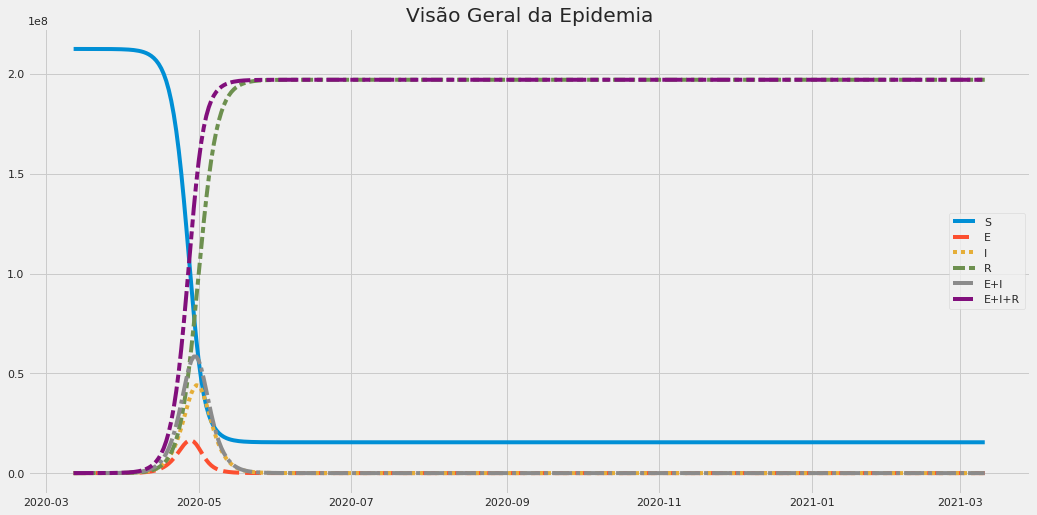

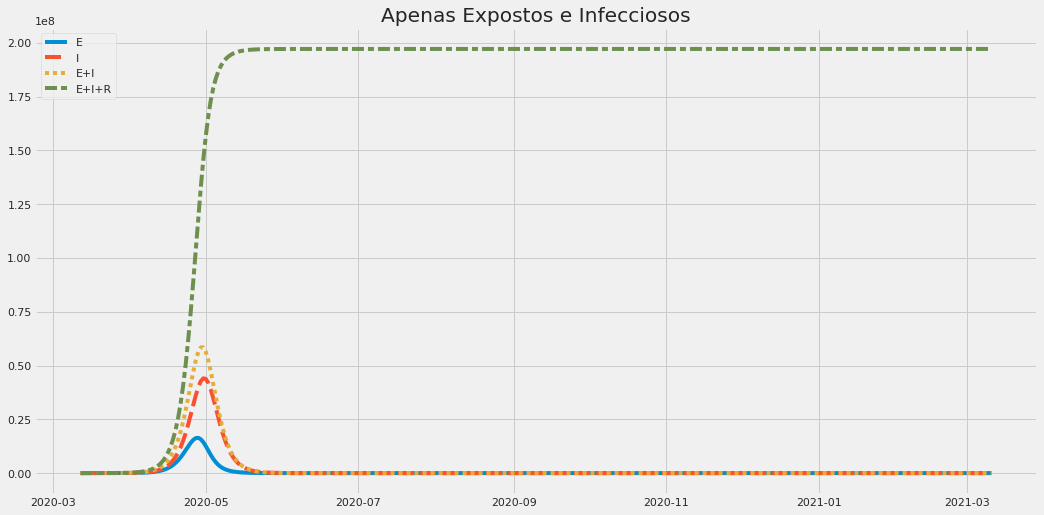

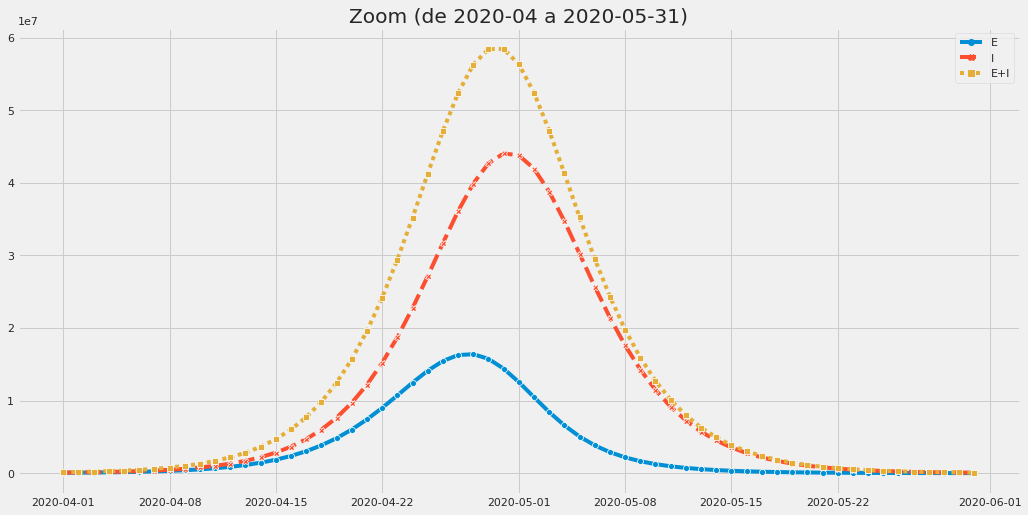

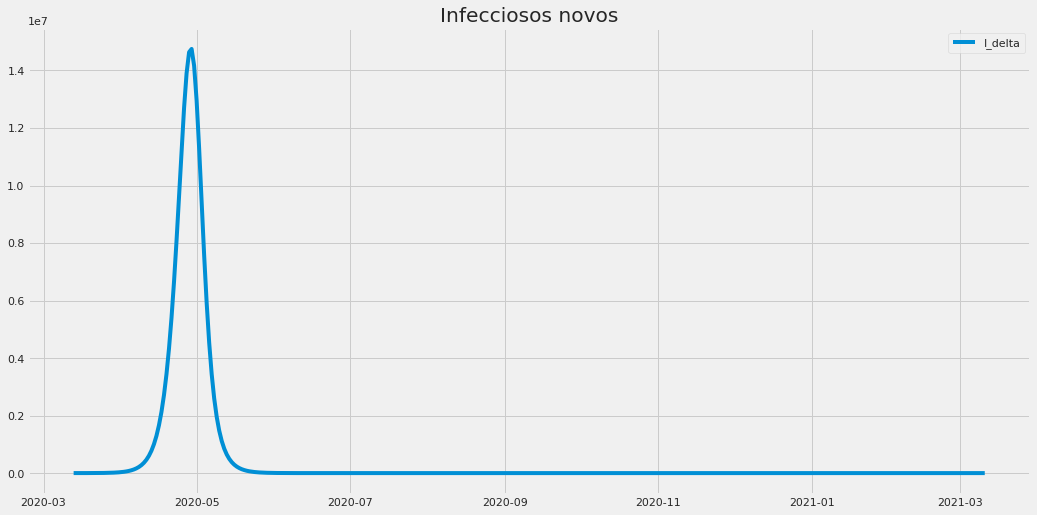

<Figure size 1152x576 with 0 Axes>

In [36]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-04')
df_simulation_data.head()

Como isso se compara visualmente com os dados reais observados?

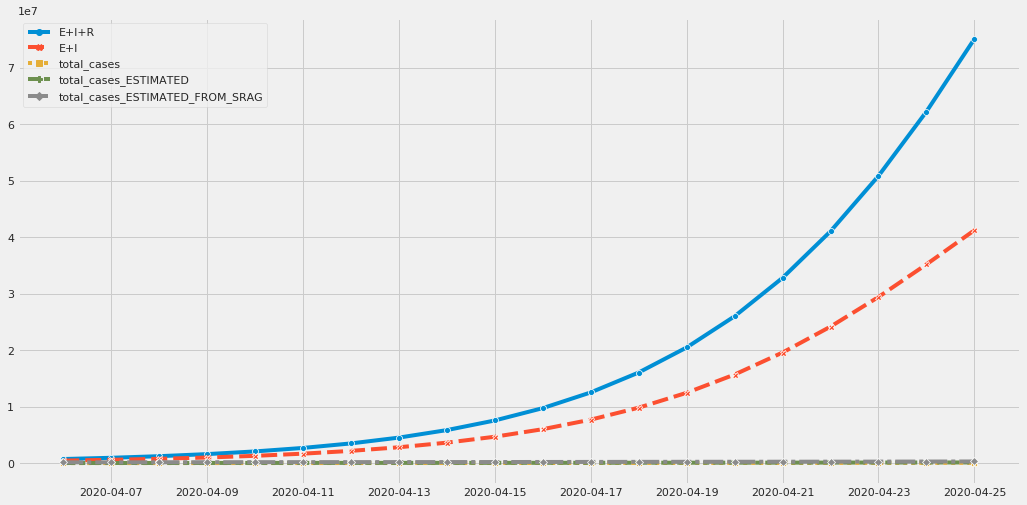

In [37]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=7)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_FROM_SRAG']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Vejamos um exemplo agora de parâmetro dinâmico. Vamos definir o parâmetro *beta* como 0.3 nos primeiros 30 dias, 0.25 nos 60 dias seguintes e 0.2 daí em diante.

In [38]:
alpha = 1.0

beta = dynamic_parameter([(0.9, 10), 
                          (0.8, epidemic_duration_in_days)], min_length=epidemic_duration_in_days)

gamma = 0.4

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-12,2.125586e+08,780.000000,0.000000,0.000000,0.000000,0.00000,0.00000,780.000000,780.000000
2020-03-13,2.125586e+08,0.000000,0.000000,780.000000,780.000000,0.00000,0.00000,780.000000,780.000000
2020-03-14,2.125579e+08,701.997424,701.997424,468.000000,0.000000,312.00000,312.00000,1169.997424,1481.997424
2020-03-15,2.125575e+08,421.197063,421.197063,982.797424,701.997424,499.20000,187.20000,1403.994487,1903.194487
2020-03-16,2.125566e+08,884.509762,884.509762,1010.875518,421.197063,892.31897,393.11897,1895.385280,2787.704249


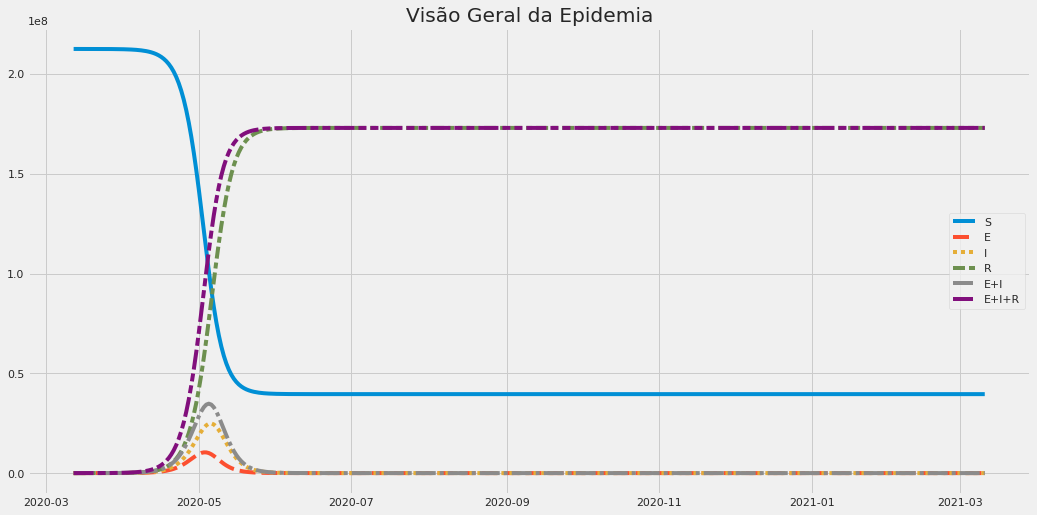

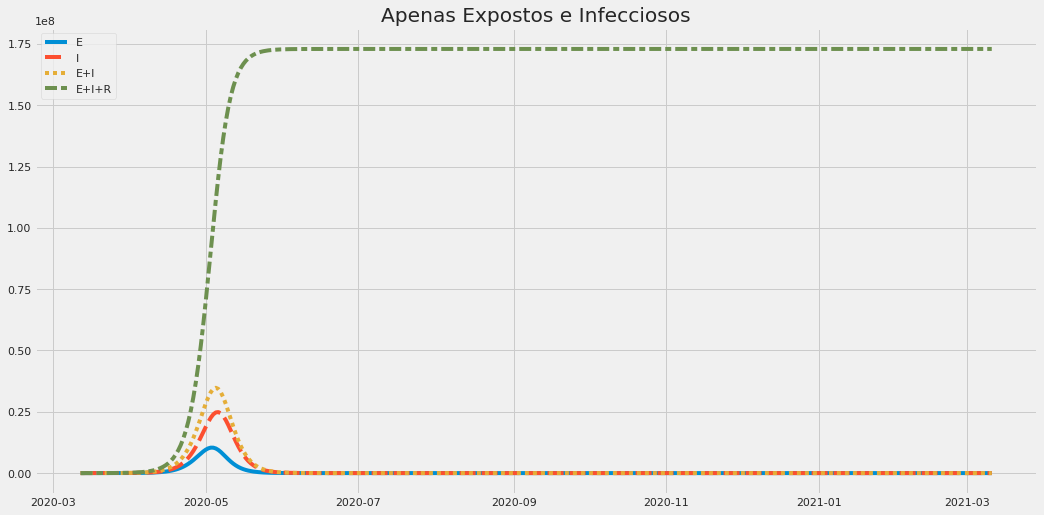

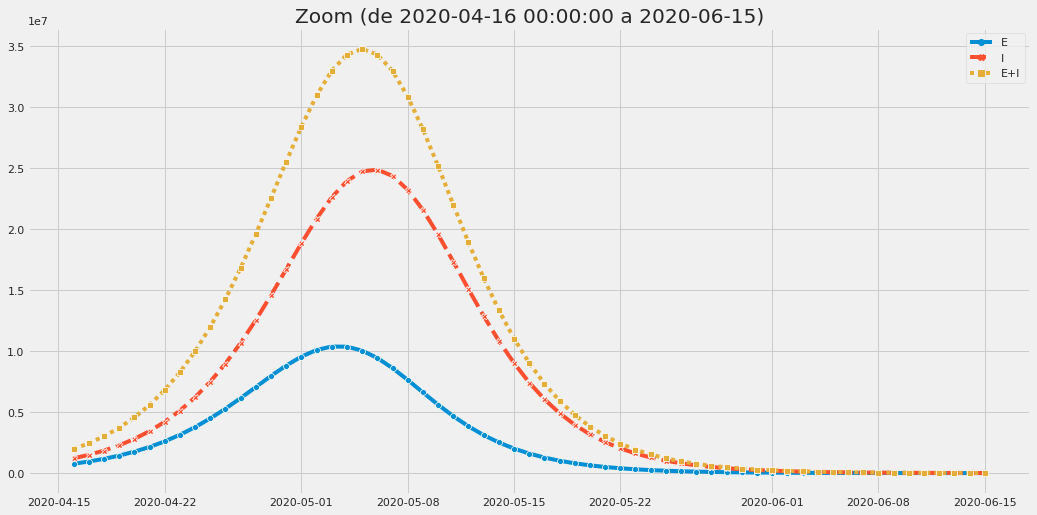

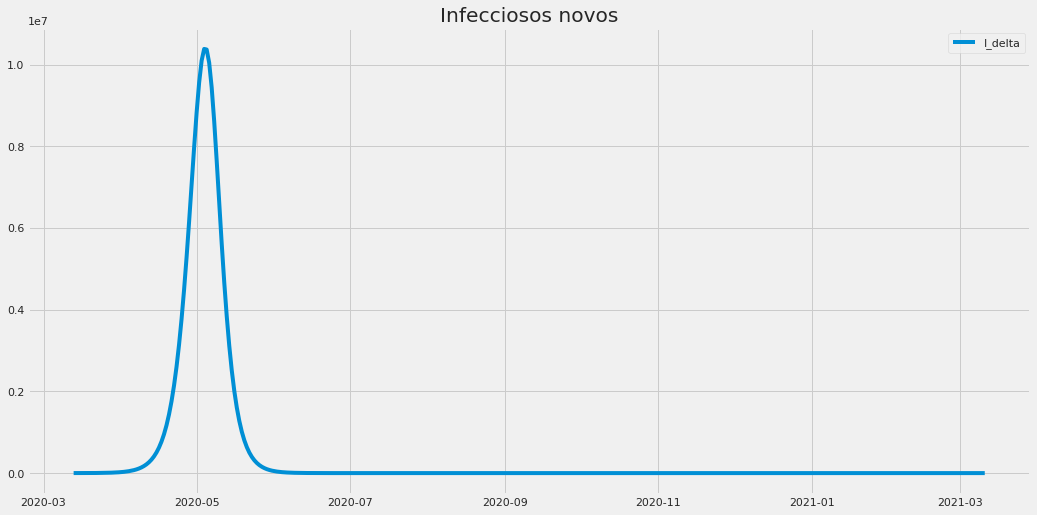

<Figure size 1152x576 with 0 Axes>

In [39]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data.head()

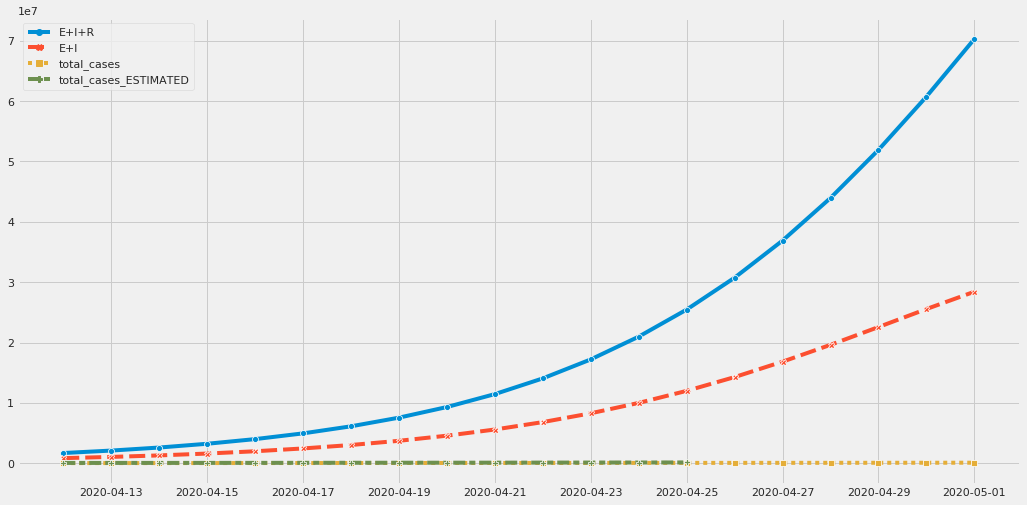

In [40]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=1)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

## Calibragem de Parâmetros

Podemos agora confrontar os modelos acima com dados reais observados e, assim, encontrar os parâmetros que melhor aproximam a realidade.

Faremos a busca de parâmetros empregando a biblioteca [hyperopt](https://github.com/hyperopt/hyperopt). Para tanto, precisamos definir uma função objetivo a ser otimizada. Aqui, essa função executa uma simulação com os parâmetros (*alpha*, *beta* e *gamma*) sugeridos, obtém a curva de infecções resultante e calcula o erro absoluto médio com relação às datas para as quais temos as observações reais.

In [41]:
def objective_for_simulation(args):
    ##################################################################
    # What kind of parameters we are optimizing? Constant or dynamic?
    ##################################################################
    if 'constant' in args:
        alpha, beta, gamma, t_min, t_max = args['constant']
    elif 'dynamic' in args:
        params_sets, t_min, t_max = args['dynamic'] # TODO
        alpha = []
        beta = []
        gamma = []
        prev_alpha = None
        prev_beta = None
        prev_gamma = None
        prev_duration = None
        for params in params_sets:
            cur_alpha = params.get('alpha', prev_alpha)
            cur_beta = params.get('beta', prev_beta)
            cur_gamma = params.get('gamma', prev_gamma)
            cur_duration = int(params.get('duration', prev_duration))
            
            alpha.append((cur_alpha, cur_duration))
            beta.append((cur_beta, cur_duration))
            gamma.append((cur_gamma, cur_duration))
            
            prev_alpha = cur_alpha
            prev_beta = cur_beta
            prev_gamma = cur_gamma
            prev_duration = cur_duration
        
        alpha = dynamic_parameter(alpha, min_length=epidemic_duration_in_days)
        beta = dynamic_parameter(beta, min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter(gamma, min_length=epidemic_duration_in_days)
        
    ###########
    # Simulate
    ###########
    df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha,beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,  
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)
    
    # run simulation
    df_simulation_data_filtered = df_simulation_data[df_simulation_data.index.isin(df_data_target.index.values)]
    
    ###################
    # Calculate error
    ###################
    df_diff_cases = df_data_target[data_column_to_fit] - \
                               (df_simulation_data_filtered['I'] + df_simulation_data_filtered['E'] + df_simulation_data_filtered['R'])
    
    # we can limit the temporal reach of the estimation if desired
    if t_min is not None and t_max is not None:
        df_diff_cases = df_diff_cases.iloc[t_min:t_max] 
    
    values = df_diff_cases.dropna().values

    mae = np.mean(abs(values)) #mean absolute error

    return mae

### Com Parâmetros Constantes

Suponhamos que os parâmetros do modelo sejam constantes, ou seja, que não haja mudanças de comportamento ou políticas ao longo da epidemia.

Definimos então o espaço de busca dos parâmetros e efetivamente executamos a busca.

In [42]:
#space = {'constant': (hyperopt.hp.uniform('alpha', 0.0, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, None)}
space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, 15)}

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=1000, trials=trials)

print("Best parameters found:", best)

100%|██████████| 1000/1000 [00:17<00:00, 56.40trial/s, best loss: 1227.5152371664126]
Best parameters found: {'alpha': 0.9933522813229488, 'beta': 0.9803747964373298, 'gamma': 0.4786698016238194}


In [43]:
#trials.losses()
#pd.Series(trials.losses()).plot(title='Loss during optimiztion')

Podemos então executar o modelo com os parâmetros encontrados e examinar as curvas de progressão da epidemia.

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-16,2.125565e+08,951.555668,948.856005,907.978201,403.404024,1029.982041,463.284924,1859.533869,2889.515910
2020-03-17,2.125556e+08,896.472517,890.146843,1418.586449,945.229994,1464.603786,434.621745,2315.058967,3779.662753
2020-03-18,2.125542e+08,1396.681169,1390.721672,1630.064975,890.513020,2143.638280,679.034494,3026.746144,5170.384424
2020-03-19,2.125526e+08,1607.320489,1598.035746,2237.198522,1387.396425,2923.901159,780.262878,3844.519012,6768.420170
2020-03-20,2.125504e+08,2203.908220,2193.223206,2762.954624,1596.635475,3994.780531,1070.879373,4966.862845,8961.643376


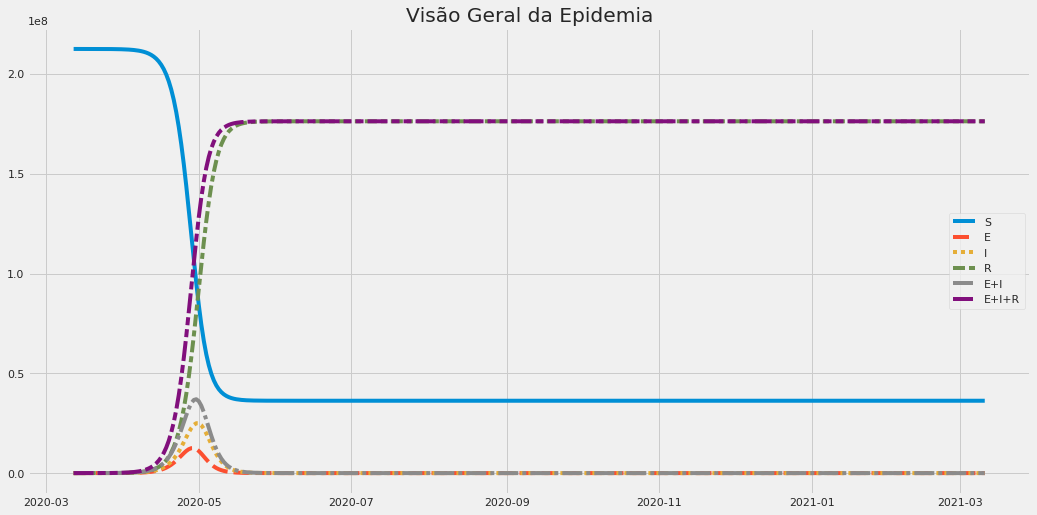

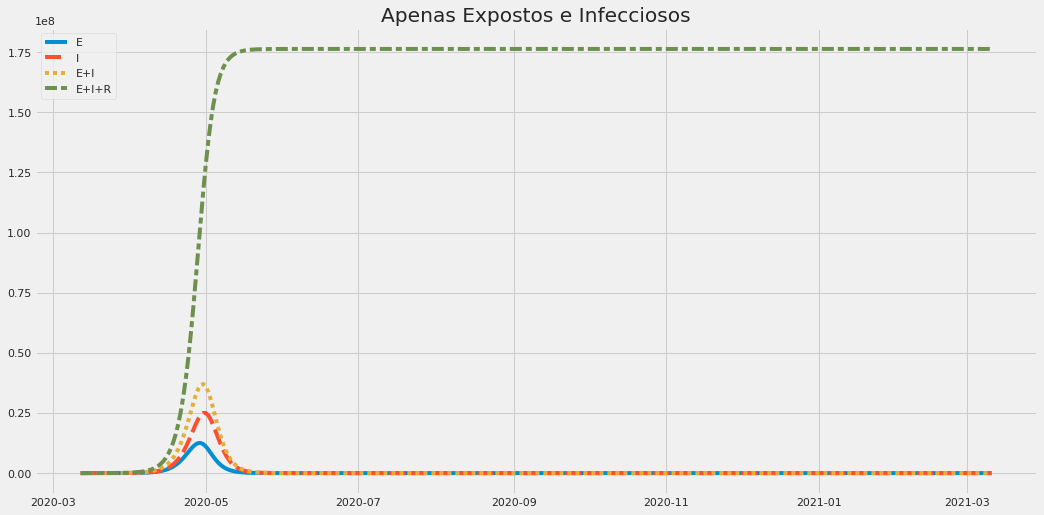

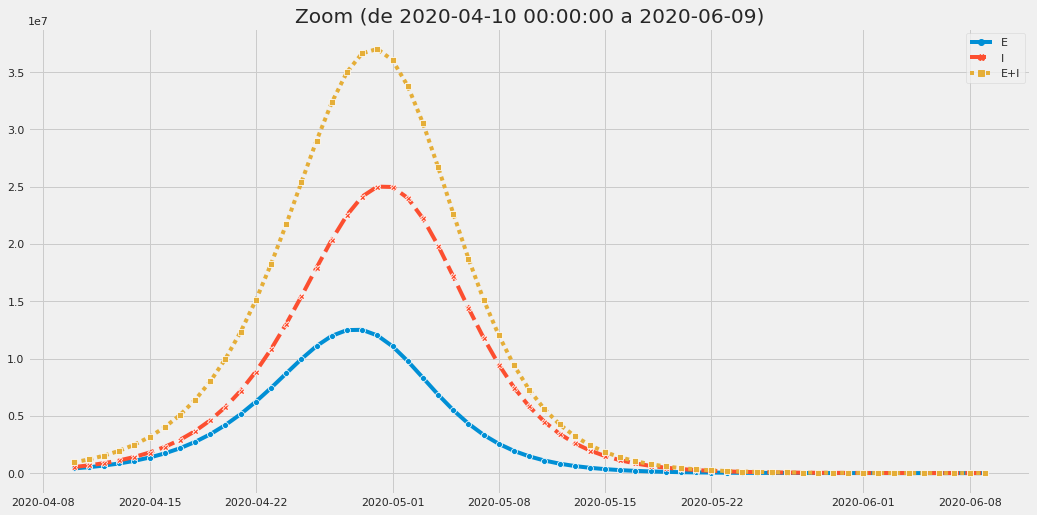

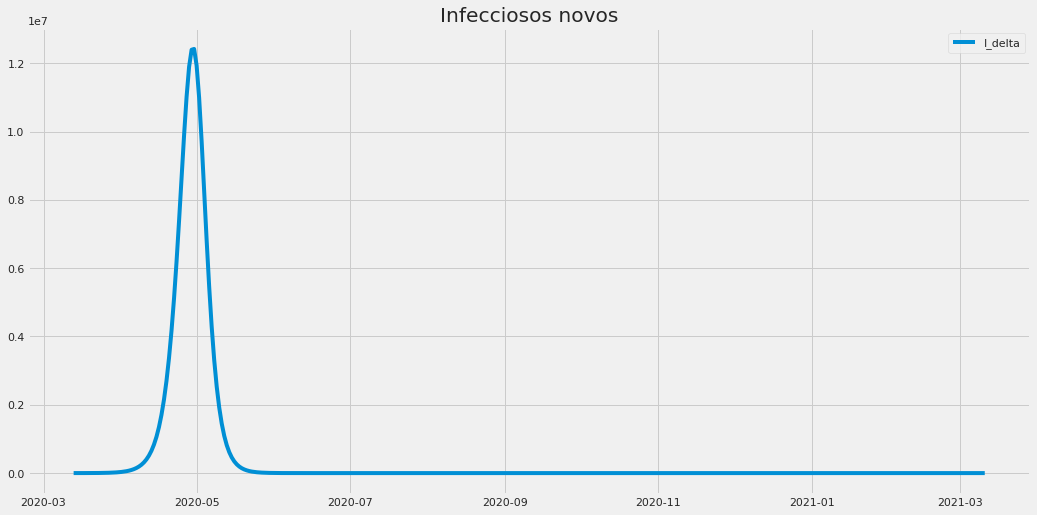

<Figure size 1152x576 with 0 Axes>

In [44]:
alpha = best['alpha']
beta  = best['beta']
gamma = best['gamma']

df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data['2020-03-16':'2020-05-01'].head()

Como isso se compara visualmente com os dados reais observados?

In [45]:
df_data_target.tail()

,new_cases,new_deaths,total_cases,total_deaths,countriesAndTerritories,continent,population_year,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,,,,
2020-04-28,4613,338,66501,4543,Brazil,South America,2020.0,212559409.0,NaN,997515,347322.343559
2020-04-29,5385,474,71886,5017,Brazil,South America,2020.0,212559409.0,NaN,1078290,366681.872391
2020-04-30,6276,449,78162,5466,Brazil,South America,2020.0,212559409.0,NaN,1172430,389244.621312
2020-05-01,7218,435,85380,5901,Brazil,South America,2020.0,212559409.0,NaN,1280700,415193.939623
2020-05-02,6209,428,91589,6329,Brazil,South America,2020.0,212559409.0,NaN,1373835,437515.817898


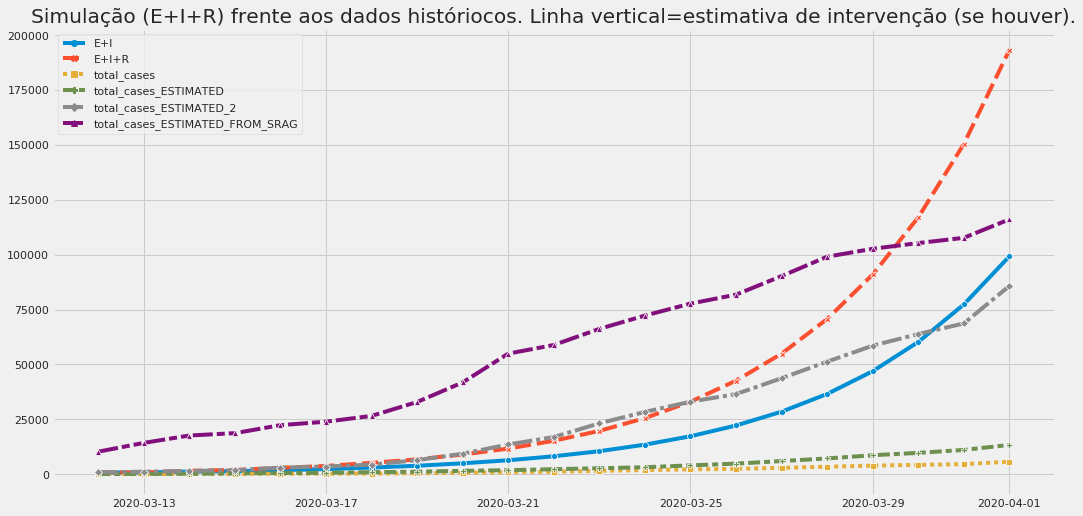

In [46]:
plot_curve_fitting(df_simulation_data=df_simulation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   comparison_date=pd.Timestamp('2020-04-01'),
                   best=best)

Salvemos os resultados.

In [47]:
df_simulation_data.to_csv(results_folder + f'seir_model_output.{target_location.lower()}.csv')

### Com Parâmetros Dinâmicos

Vamos experimentar agora introduzindo a possibilidade de aprender medidas de mitigação após o início do surto. Ou seja, experimentaremos com dois grupos de parâmetros: aqueles *antes* das medidas, e aqueles *depois* das medidas. Esses dois conjuntos de parâmetros serão estimados a partir dos dados fornecidos.

In [48]:
## assuming different gammas
#
#space = \
#    {'dynamic':\
#        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_1', 1.0, 10.0)}, 
#           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_2', 1.0, 10.0)},
#         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_3', 1.0, 10.0)}], 
#        0, 60)
#    }

# assuming gamma_1 == gamma_2 == gamma_3
space = \
    {'dynamic':\
        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
           'duration': hyperopt.hp.uniform('duration_1', 1.0, 20.0)}, 
           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_2', 1.0, 20.0)},
         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_3', 1.0, 20.0)}], 
        0, 60)
    }

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

print("Best parameters found:", best)

100%|██████████| 3000/3000 [03:33<00:00, 14.05trial/s, best loss: 14520.289221475958]
Best parameters found: {'alpha_1': 0.9955966716248936, 'alpha_2': 0.9900097055903969, 'alpha_3': 0.9955241640212104, 'beta_1': 0.8623221678282829, 'beta_2': 0.5740297841873131, 'beta_3': 0.5888309446768698, 'duration_1': 18.67623904678535, 'duration_2': 16.39374553517568, 'duration_3': 13.668336711122224, 'gamma_1': 0.4691264578185234}


In [49]:
alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                            (best['alpha_2'], best['duration_2']),
                            (best['alpha_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                            (best['beta_2'], best['duration_2']),
                            (best['beta_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

## assuming different gammas
#
#gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
#                            (best['gamma_2'], best['duration_2']),
#                            (best['gamma_3'], best['duration_3'])],
#                            min_length=epidemic_duration_in_days)
#


# assuming gamma_1 == gamma_2 == gamma_3
gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                            (best['gamma_1'], best['duration_2']),
                            (best['gamma_1'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

Comparando as versões com e sem mitigação, temos o seguinte.

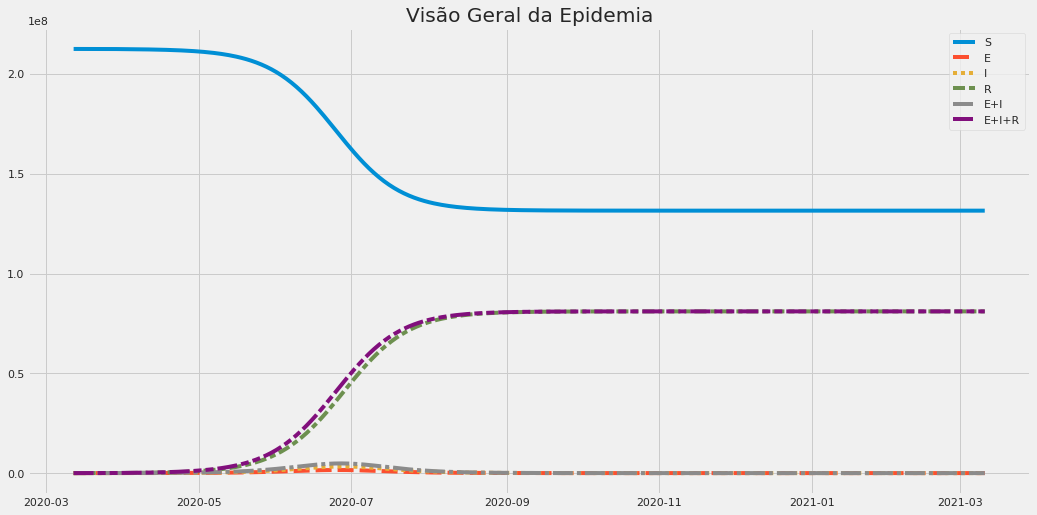

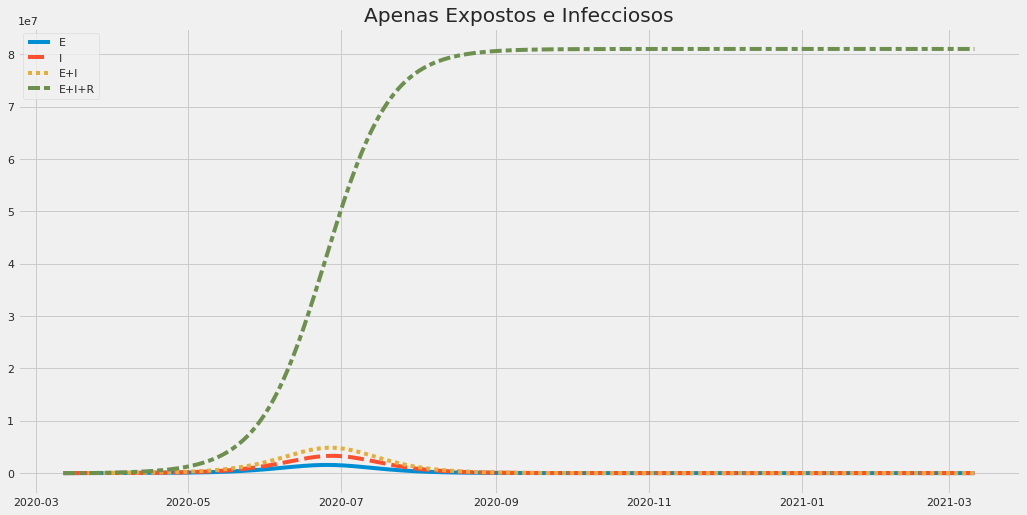

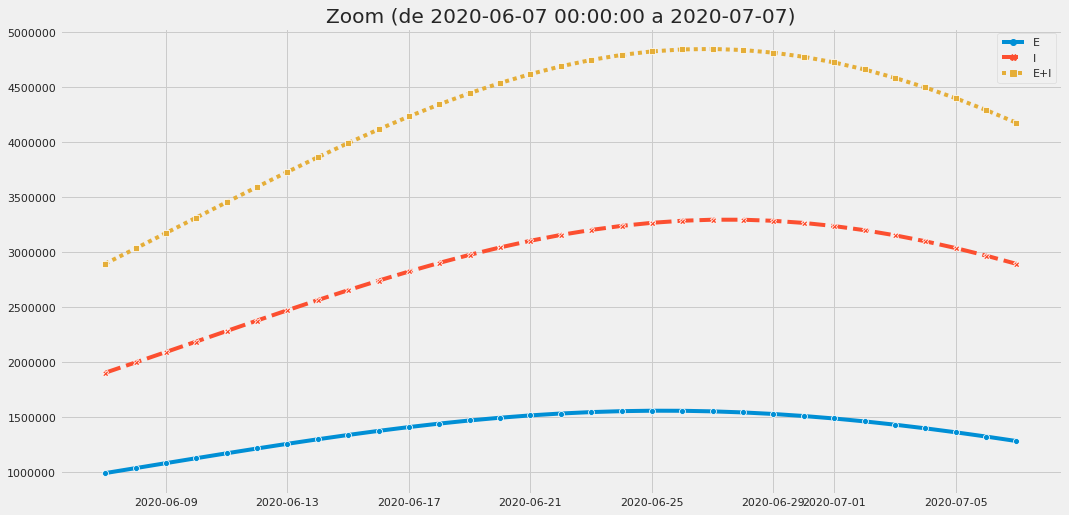

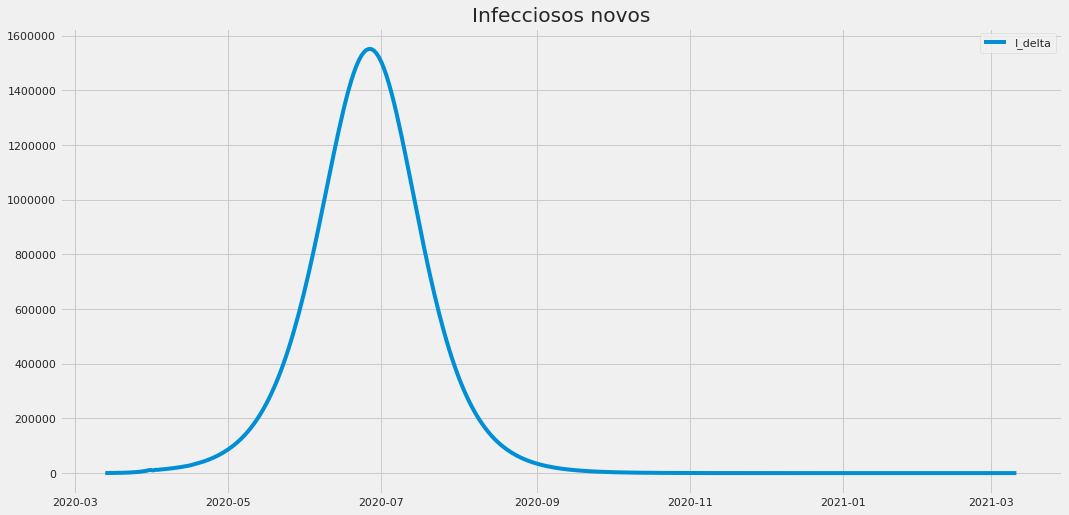

<Figure size 1152x576 with 0 Axes>

In [50]:
df_simulation_mitigation_data = simulate(S=population_size - initially_infected, 
                                          E=initially_infected,
                                          I=0,
                                          R=0, 
                                          alpha=alpha, beta=beta, gamma=gamma, 
                                          epidemic_start_date=epidemic_start_date, 
                                          epidemic_duration_in_days=epidemic_duration_in_days, 
                                          s_func=s, 
                                          e_func=e,
                                          i_func=i, 
                                          r_func=r,
                                          e_delta_func=e_delta,
                                          i_delta_func=i_delta,
                                          r_delta_func=r_delta)

plot_simulation_output(df_simulation_mitigation_data, zoom_length=30, file_name='dynamic')

In [51]:
best['beta_3'] / best['gamma_1']

1.2551646466817967

Como isso essa versão com mitigação se compara visualmente com os dados reais observados?

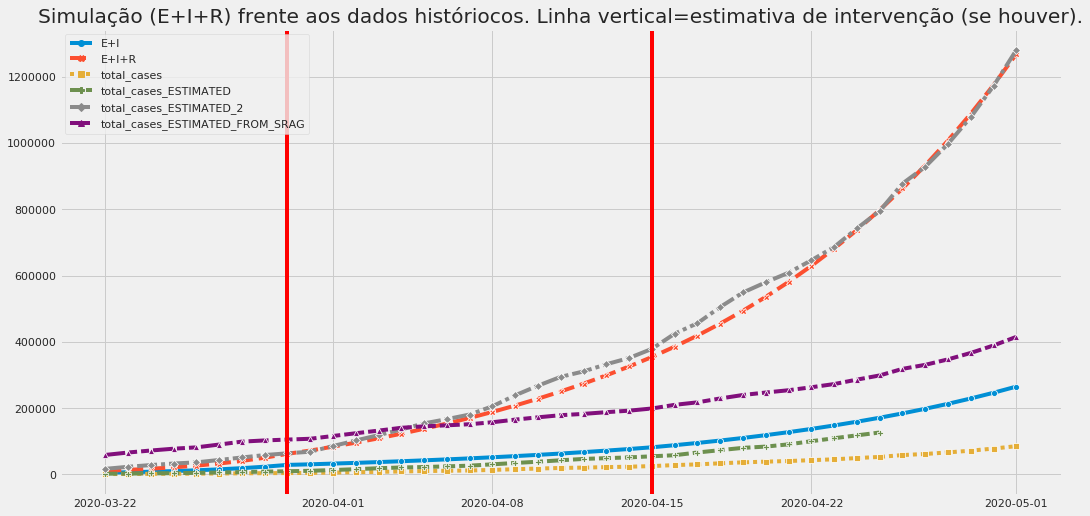

In [52]:
plot_curve_fitting(df_simulation_data=df_simulation_mitigation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   best=best, 
                   file_name='seir_dynamic_fit_zoom')

Finalmente, comparemos os casos com e sem mitigação.

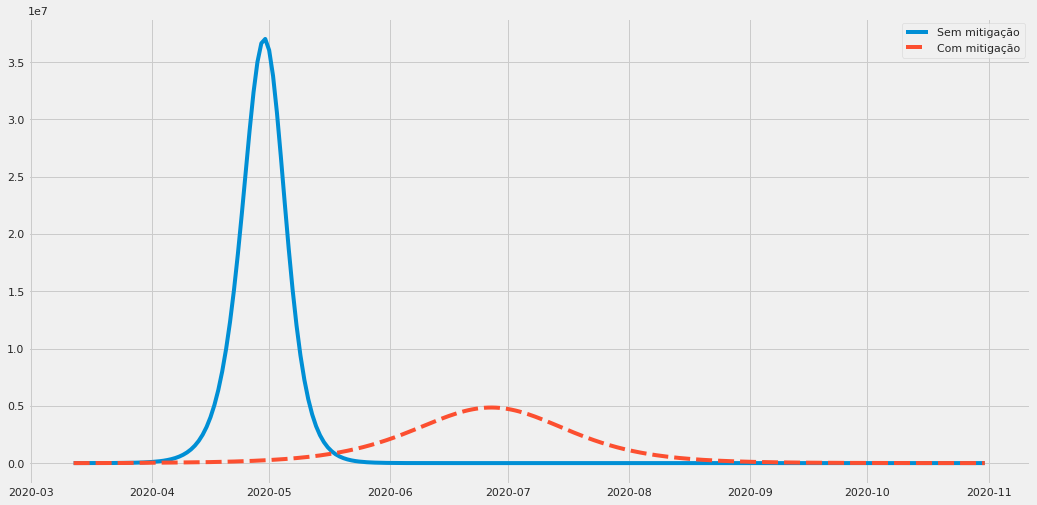

In [53]:
ax = sns.lineplot(data=pd.concat([df_simulation_data['E+I'].rename('Sem mitigação'), 
                                 df_simulation_mitigation_data['E+I'].rename('Com mitigação')], axis=1)['2020-03':'2020-10'])

ax.figure.savefig(results_folder + 'seir_constant_vs_dynamic' + f'_{target_location.lower()}' + results_suffix + '.png', 
                  format='png')

Salvemos os resultados.

In [54]:
df_simulation_mitigation_data.to_csv(results_folder + f'seir_dynamic_model_output.{target_location.lower()}.csv')

## Estudo de Calibragem de Parâmetros Variando-se Pontos de Corte Históricos 

Podemos também considerar o que ocorre com o treino do modelo conforme adquirimos mais dados históricos, simulando o ajuste do modelo ao longo de algumas janelas de tempo.

In [58]:
len(df_data_target)

52

In [59]:
%%time
ss = []
r0s = []
for t in range(7, len(df_data_target), 1):
    print(f'###### t={t} ######')
    #space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, t)}
    
    t_2 = 10 if t >= 15.0 else 0.1
    t_3 = 10 if t >= 20.0 else 0.1
    
    ## assuming different gammas
    #
    #space = \
    #    {'dynamic':\
    #        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
    #           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
    #           'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
    #           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
    #           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
    #           'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
    #         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
    #           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
    #           'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
    #        0, t)
    #    }
    
    # assuming gamma_1 == gamma_2 == gamma_3
    space = \
        {'dynamic':\
            ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
               'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
               'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
               {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
               'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
             {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
               'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
            0, t)
        }
    
    trials = hyperopt.Trials()
    best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

    print("Best parameters found:", best)
    
    alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                                (best['alpha_2'], best['duration_2']),
                                (best['alpha_3'], best['duration_3'])],
                                min_length=epidemic_duration_in_days)
    beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                                (best['beta_2'], best['duration_2']),
                                (best['beta_3'], best['duration_3'])],
                                min_length=epidemic_duration_in_days)
   #gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
   #                            (best['gamma_2'], best['duration_2']),
   #                            (best['gamma_3'], best['duration_3'])],
   #                            min_length=epidemic_duration_in_days)
    gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                                (best['gamma_1'], best['duration_2']),
                                (best['gamma_1'], best['duration_3'])],
                                min_length=epidemic_duration_in_days)
    
    r0_1 = best['beta_1'] / best['gamma_1']
    r0_2 = best['beta_2'] / best['gamma_1'] # / best['gamma_2']
    r0_3 = best['beta_3'] / best['gamma_1'] # / best['gamma_3']
    
    r0s.append((r0_1, r0_2, r0_3))
    print(f'R0_1={r0_1}, R0_2={r0_2}, R0_3={r0_3}')
    
    
    df_simulation_partial_data = simulate(S=population_size - initially_infected, 
                                              E=initially_infected,
                                              I=0,
                                              R=0, 
                                              alpha=alpha, beta=beta, gamma=gamma, 
                                              epidemic_start_date=epidemic_start_date, 
                                              epidemic_duration_in_days=epidemic_duration_in_days, 
                                              s_func=s, 
                                              e_func=e,
                                              i_func=i, 
                                              r_func=r,
                                              e_delta_func=e_delta,
                                              i_delta_func=i_delta,
                                              r_delta_func=r_delta)

    ss.append(df_simulation_partial_data['E+I'].rename(f'E+I, t <= {t}'))
    #ax = sns.lineplot(data=df_simulation_partial_data['E+I']['2020-03':'2020-07'])

###### t=7 ######
100%|██████████| 3000/3000 [03:29<00:00, 14.30trial/s, best loss: 85.70498250709173]
Best parameters found: {'alpha_1': 0.9955224508968796, 'alpha_2': 0.998840326546047, 'alpha_3': 0.9941752266606612, 'beta_1': 0.8922709686405039, 'beta_2': 0.9494471145176807, 'beta_3': 0.402479744069304, 'duration_1': 4.452708257333175, 'duration_2': 0.04054803794493973, 'duration_3': 0.08611475078252348, 'gamma_1': 0.2525936818637404}
R0_1=3.5324358157217572, R0_2=3.758792015351564, R0_3=1.5933880099440427
###### t=8 ######
100%|██████████| 3000/3000 [03:30<00:00, 14.24trial/s, best loss: 141.6057374225174] 
Best parameters found: {'alpha_1': 0.995942765820878, 'alpha_2': 0.9940102352594887, 'alpha_3': 0.9998309484230568, 'beta_1': 0.8512398864517404, 'beta_2': 0.6747819128283711, 'beta_3': 0.9997218254468965, 'duration_1': 6.4305147254945645, 'duration_2': 0.03794285869636849, 'duration_3': 0.08052346512961593, 'gamma_1': 0.38793363309691353}
R0_1=2.194292564055883, R0_2=1.73942616

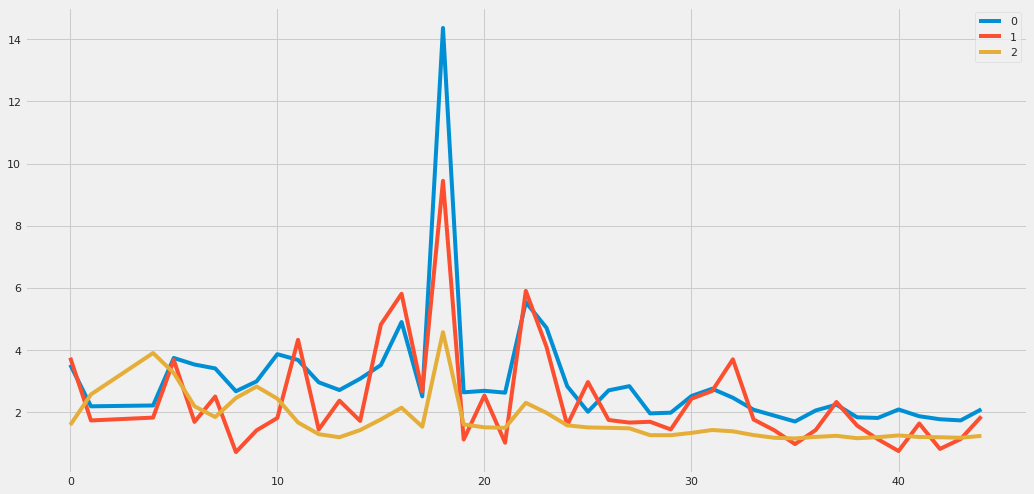

In [60]:
df_r0 = pd.DataFrame(r0s)
df_r0 = df_r0[df_r0 < 25]#.rolling(3).mean()
ax = sns.lineplot(data=df_r0, dashes=False)

In [61]:
df = pd.concat(ss, axis=1)['2020-03':'2020-09']

Text(0.5, 1.0, 'Comparação de diversos pontos de corte (t) nos dados históricos')

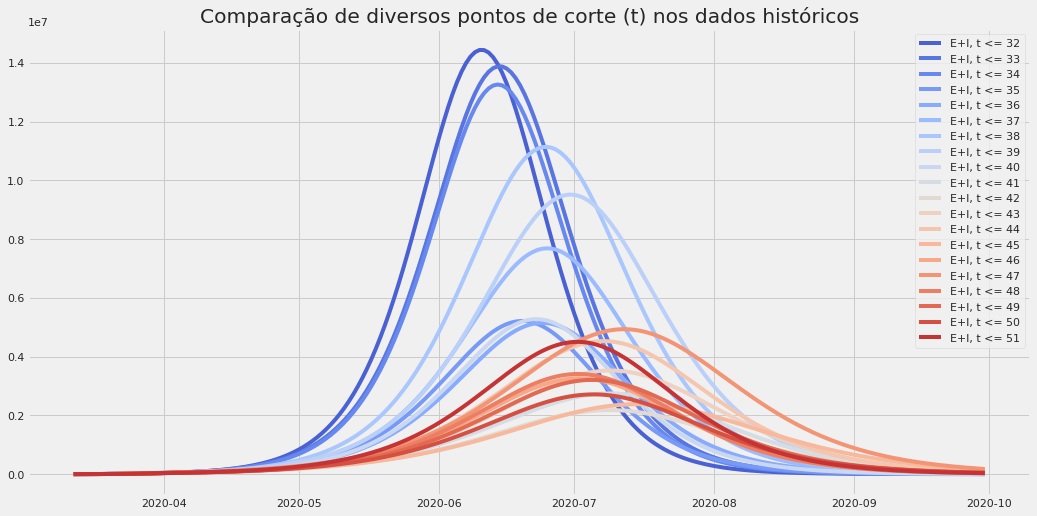

In [65]:
df_filtered = df.iloc[:, 25:]
palette = sns.color_palette("coolwarm", len(df_filtered.columns))
ax = sns.lineplot(data=df_filtered, dashes=False, palette=palette)
ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

Text(0.5, 1.0, 'Comparação de diversos pontos de corte (t) nos dados históricos')

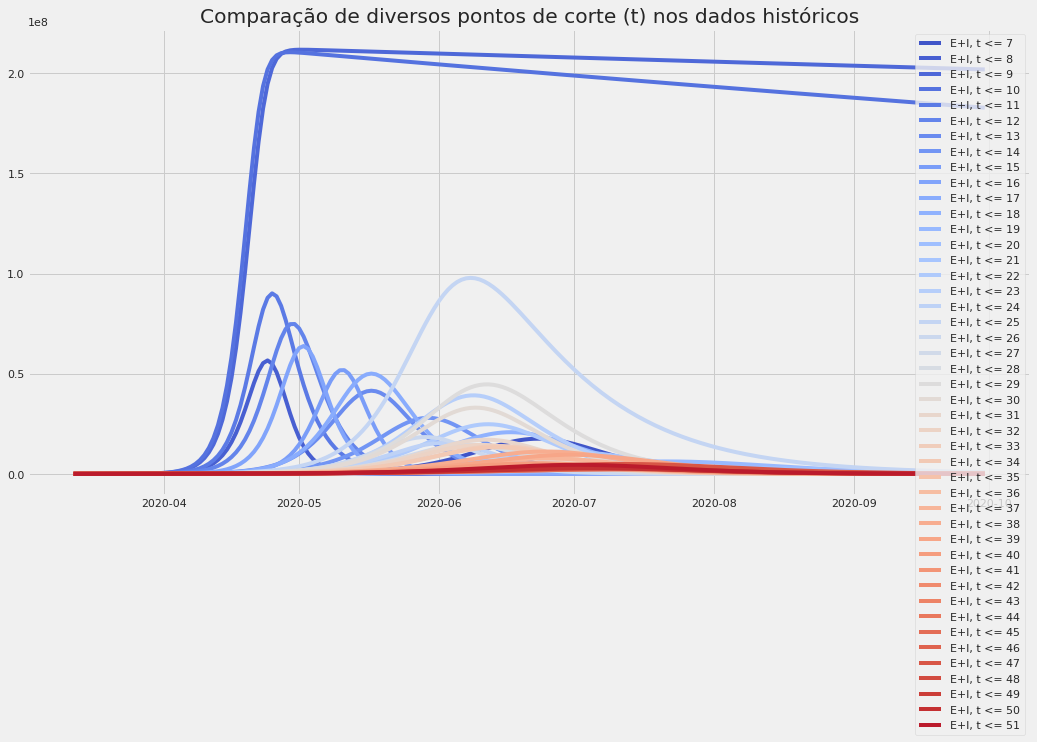

In [63]:
palette = sns.color_palette("coolwarm", len(df.columns))
ax = sns.lineplot(data=df, dashes=False, palette=palette)
ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

In [64]:
ax.figure.savefig(results_folder + 'seir_multiple_historical_fits_2' + f'_{target_location.lower()}' + results_suffix + '.png', 
                  format='png')

df.head()

,"E+I, t <= 7","E+I, t <= 8","E+I, t <= 9","E+I, t <= 10","E+I, t <= 11","E+I, t <= 12","E+I, t <= 13","E+I, t <= 14","E+I, t <= 15","E+I, t <= 16",...,"E+I, t <= 42","E+I, t <= 43","E+I, t <= 44","E+I, t <= 45","E+I, t <= 46","E+I, t <= 47","E+I, t <= 48","E+I, t <= 49","E+I, t <= 50","E+I, t <= 51"
2020-03-12,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,...,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000
2020-03-13,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,...,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000
2020-03-14,1276.711676,1139.910252,1405.234009,1363.182087,1198.530141,1200.773162,1200.452056,1200.767679,1197.284953,1207.000039,...,1100.128501,1130.991312,1146.472853,1088.786253,1112.444475,1052.526819,1129.144522,1077.400326,1093.647079,1146.741260
2020-03-15,1650.179473,1361.658186,1815.537188,1788.078844,1541.493467,1539.729341,1533.174255,1529.604457,1483.145517,1517.637320,...,1234.122118,1334.125178,1375.801185,1253.333086,1272.864400,1239.304150,1300.530583,1230.459520,1238.343874,1357.488191
2020-03-16,2370.532487,1802.511093,2553.127987,2529.879116,2122.671308,2121.578517,2110.839524,2105.504647,2033.633640,2093.736191,...,1607.724288,1757.483200,1828.631586,1607.495194,1663.985963,1548.279155,1718.697808,1566.963496,1600.164790,1807.018252


Vemos que há grande sensibilidade do modelo frente a pequenos ajustes nos parâmetros de entrada, embora a maior quantidade de dados favoreça maior estabilidade.